# CIMS Tutorial


CIMS stands for Current Induced Magnetisation Switching. In this method, we excite the magnetisation with a current pulse which, as we will show here can take different forms: 
sometimes it's a step function, Gaussian impulse or a sinc impulse. The choice of the current pulse, and its duration, is important as it can affect the magnetisation dynamics.

After magnetisation is excited we measure the resistance level in a stable state. This resistance level is a function of the magnetisation direction and can be used to determine the magnetisation direction -- and thus, by scanning with the magnitude of the excitation, we can determine the hysteresis curve of the device. 

In this tutorial, we will show how to simulate the CIMS method using the `cmtj` package. We will simulate the magnetisation dynamics of a trilayer and a bilayer devices in function not only of a current density magnitude, but also applied field and, for a trilayer system, IEC (coupling) and anisotropy.

# Trilayer CIMS

In [1]:
import multiprocess as mp
from functools import partial
from cmtj import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmtj.utils import OetoAm, calculate_resistance_parallel
from cmtj.utils.linear import FieldScan
from tqdm import tqdm


def compute_hyst_params(hysteresis, x_axis):
    # sort according to X first
    sorted_hyst = [
        x for _, x in sorted(zip(x_axis, hysteresis), key=lambda pair: pair[0])
    ]
    Rval = np.asarray(sorted_hyst)
    Jscan = np.asarray(x_axis)
    # take only the ones on the right hand side
    Rval = Rval[Jscan >= 0]
    Jpos = Jscan[Jscan >= 0]
    diff = np.diff(Rval, n=1)
    low_indx, high_indx = 0, 0
    eps = 0.01
    for i, d in enumerate(diff):
        if np.abs(d) > eps:
            low_indx = i
            high_indx = i + 1
            break

    slew = np.abs(Jpos[high_indx] - Jpos[low_indx])
    width = (Jpos[high_indx] + Jpos[low_indx]) / 2
    return slew, width, Jpos[low_indx]


def critical_current_detection(hysteresis, j_scan):
    """
    This has to be one way hysteresis
    """
    assert len(np.unique(j_scan)) == len(j_scan)
    j_scan = np.asarray(j_scan)
    x = np.abs(np.diff(hysteresis))
    transition_threshold = (np.max(hysteresis) - np.min(hysteresis)) / 2
    y = np.argwhere(x >= transition_threshold).ravel()
    if len(y) > 2:
        print("Warning: more than 2 transitions detected")
        return 0
    if len(y) > 1:
        return np.min(j_scan[y])
    elif len(y) == 1:
        return j_scan[y][0]
    return -1e12

In [2]:
def compute_cims_trilayer(
    field: float, J: float, j_scan: np.ndarray, Ms: float, Ku: float, Kudir_theta: float
):
    #  define some device parameters
    t_fm = 1e-9
    w = 10e-6
    l = 80e-6
    area = w * l
    demagTensor = [
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 0.0),
        CVector(0.0, 0.0, 1.0),
    ]
    alpha = 0.05
    # torque parameters
    # The Hdl/Hfl  is in units A/m per (A/m^2) = 1/m
    jden = 4.24e10
    HDL = 5.86e1 * OetoAm / jden
    HFL = 1.25e2 * OetoAm / jden
    Kdir = FieldScan.angle2vector(Kudir_theta, 0)
    layer_free = Layer.createSOTLayer(
        id="free",
        mag=CVector(0.0, 0.0, 1.0),
        anis=CVector(0.0, 0.0, 1),
        Ms=Ms,
        thickness=t_fm,
        cellSurface=area,
        demagTensor=demagTensor,
        damping=alpha,
        dampingLikeTorque=HDL,
        fieldLikeTorque=HFL,
    )

    layer_bottom = Layer.createSOTLayer(
        id="bottom",
        mag=Kdir,
        anis=Kdir,
        Ms=Ms,
        thickness=t_fm,
        cellSurface=area,
        demagTensor=demagTensor,
        damping=alpha,
        dampingLikeTorque=HDL * 0.4,  # add some asymmetry (just to make it interesting)
        fieldLikeTorque=HFL * 0.4,
    )

    j = Junction([layer_free, layer_bottom])
    j.setLayerAnisotropyDriver("free", ScalarDriver.getConstantDriver(0.455e6))
    j.setLayerAnisotropyDriver("bottom", ScalarDriver.getConstantDriver(Ku))
    j.setLayerReferenceLayer("free", CVector(0.0, 1, 0))
    j.setLayerReferenceLayer("bottom", CVector(0.0, 1, 0))
    j.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J))
    j.setLayerExternalFieldDriver(
        "all",
        AxialDriver(
            ScalarDriver.getConstantDriver(field),
            ScalarDriver.getConstantDriver(0),
            ScalarDriver.getConstantDriver(0),
        ),
    )

    tstep = 1e-12
    hysteresis = []
    j.setLayerMagnetisation("bottom", CVector(0, 0, -1))
    n_lay = 2
    for current in j_scan:
        j.clearLog()
        j.setLayerCurrentDriver(
            "all", ScalarDriver.getStepDriver(0, current, -1e-9, 1e-9)
        )
        j.runSimulation(8e-9, tstep, tstep)

        log = j.getLog()
        m = np.asarray(
            [
                [log[f"{str_}_mx"], log[f"{str_}_my"], log[f"{str_}_mz"]]
                for str_ in ("free", "bottom")
            ]
        )
        # some resistance parameters
        Rx0 = [100] * n_lay
        Ry0 = [9] * n_lay
        SMR = [5.11] * n_lay
        AMR = [0.41] * n_lay
        AHE = [5.5] * n_lay

        _, Rxy = calculate_resistance_parallel(
            Rx0, Ry0, AMR=AMR, AHE=AHE, SMR=SMR, m=m, l=[l] * n_lay, w=[w] * n_lay
        )
        Rstable = Rxy[-100:].mean()
        hysteresis.append(Rstable)
    end_mag_top = j.getLayerMagnetisation("free")
    end_mag_bottom = j.getLayerMagnetisation("bottom")
    hysteresis = np.asarray(hysteresis)
    Icrit = critical_current_detection(hysteresis, j_scan=j_scan)

    return (
        hysteresis,
        Icrit,
        [end_mag_top.x, end_mag_top.y, end_mag_top.z],
        [end_mag_bottom.x, end_mag_bottom.y, end_mag_bottom.z],
        field,
        J,
        Ku,
        Kudir_theta,
    )

In [3]:
I = 9.5e12
Ku = 0.237e6
n = 60
inum = 35
Hspace_k = np.linspace(0, 400e3, n + 1).tolist()[1:][::-1]
Ispace = np.linspace(0, I, num=inum)
Kuspace = np.linspace(0, 180, n).tolist()
K_res_map = np.zeros((len(Kuspace), len(Hspace_k)), dtype=np.float32)
components_top = np.zeros((len(Kuspace), len(Hspace_k), 3), dtype=np.float32)
components_bottom = np.zeros((len(Kuspace), len(Hspace_k), 3), dtype=np.float32)
hysts2 = np.zeros((len(Kuspace), len(Hspace_k), len(Ispace)), dtype=np.float32)
end_mag = CVector(0, 0, 1)
J = 4.784e-3
with mp.Pool(8) as pool:
    for Ku_ in tqdm(Kuspace):
        for result in pool.imap_unordered(
            partial(
                compute_cims_trilayer,
                j_scan=Ispace,  # min starting point
                Ms=1.13,
                J=J,
                Ku=Ku,
                Kudir_theta=Ku_,
            ),
            Hspace_k,
        ):
            (
                hists,
                Icrit,
                end_mag_components_top,
                end_mag_components_bottom,
                f,
                j,
                k,
                d,
            ) = result
            K_res_map[Kuspace.index(d), Hspace_k.index(f)] = Icrit
            components_top[Kuspace.index(d), Hspace_k.index(f)] = end_mag_components_top
            components_bottom[Kuspace.index(d), Hspace_k.index(f)] = (
                end_mag_components_bottom
            )
            hysts2[Kuspace.index(d), Hspace_k.index(f)] = hists

100%|██████████| 60/60 [03:25<00:00,  3.42s/it]


In [4]:
I = 30e12
Ku = 0.455e6
n = 50
inum = 35
Hspace_j = np.linspace(0, 400e3, n + 1).tolist()[1:]
Ispace = np.linspace(0e12, 8.1e12, num=inum)

Jspace = np.linspace(3.5e-3, 7e-3, n).tolist()
J_res_map = np.zeros((len(Jspace), len(Hspace_j)), dtype=np.float32)
components_top = np.zeros((len(Jspace), len(Hspace_j), 3), dtype=np.float32)
components_bottom = np.zeros((len(Jspace), len(Hspace_j), 3), dtype=np.float32)
hysts = np.zeros((len(Jspace), len(Hspace_j), len(Ispace)), dtype=np.float32)
with mp.Pool(32) as pool:
    for J in tqdm(Jspace):
        for result in pool.imap_unordered(
            partial(
                compute_cims_trilayer,
                j_scan=Ispace,  # min starting point
                Ms=1.13,
                J=J,
                Ku=Ku,
                Kudir_theta=60,
            ),
            Hspace_j,
        ):
            (
                hists,
                Icrit,
                end_mag_components_top,
                end_mag_components_bottom,
                f,
                j,
                k,
                d,
            ) = result
            J_res_map[Jspace.index(j), Hspace_j.index(f)] = Icrit
            components_top[Jspace.index(j), Hspace_j.index(f)] = end_mag_components_top
            components_bottom[Jspace.index(j), Hspace_j.index(f)] = (
                end_mag_components_bottom
            )
            hysts[Jspace.index(j), Hspace_j.index(f)] = hists

100%|██████████| 50/50 [02:14<00:00,  2.69s/it]


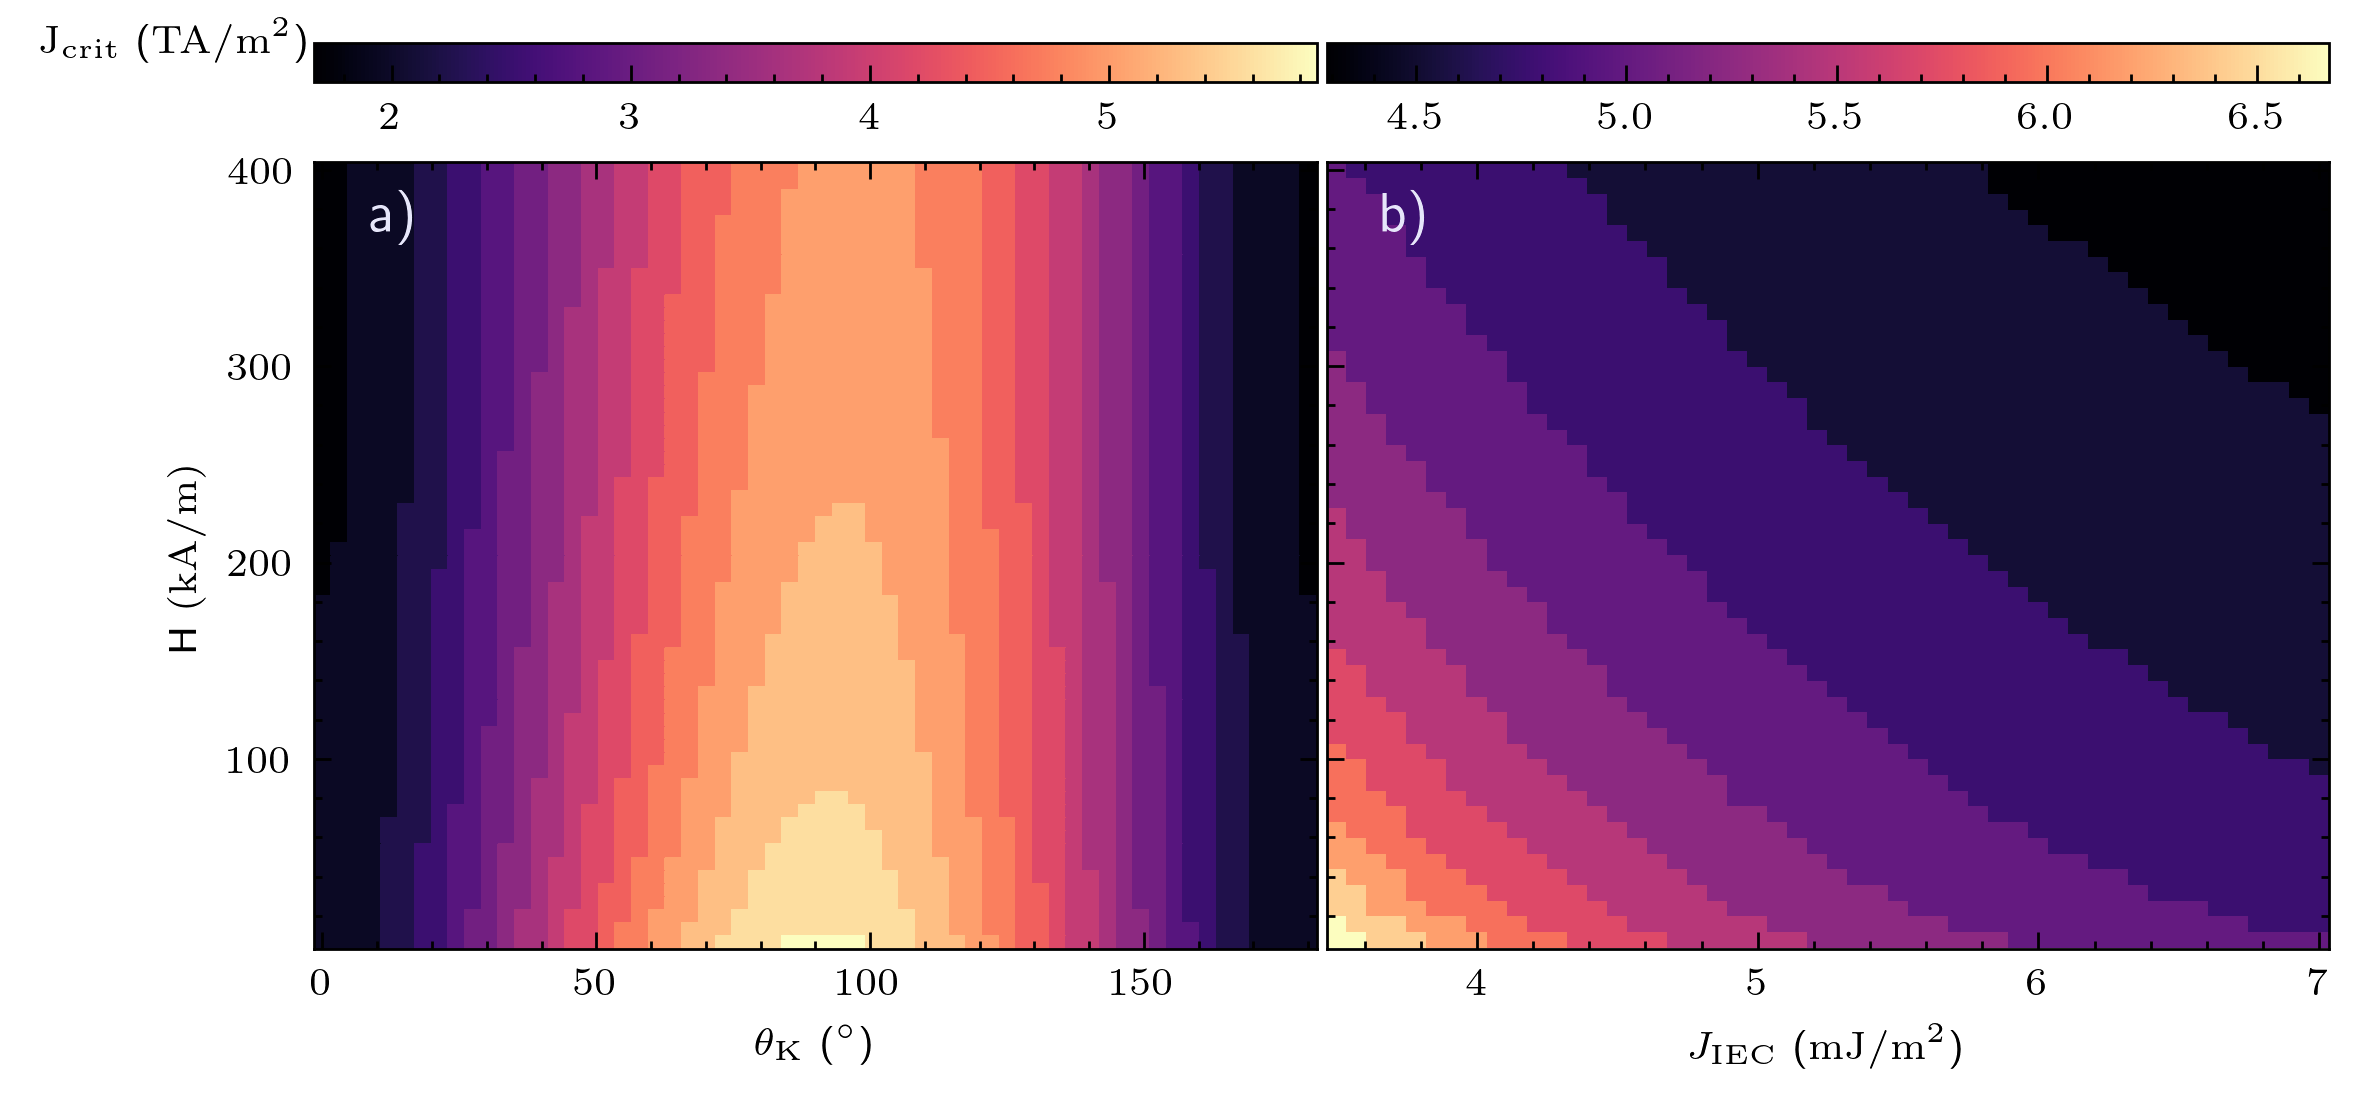

In [5]:
def colorbar(mappable, cbar_title):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="5%", pad=0.2)
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    if cbar_title:
        cbar.ax.get_yaxis().labelpad = 25
        cbar.ax.set_ylabel(cbar_title, rotation=0)
    plt.sca(last_axes)
    return cbar


with plt.style.context(['science', 'nature']):
    fig, (ax1, ax2) = plt.subplots(1,
                                   2,
                                   sharey='row',
                                   figsize=(6.5, 3),
                                   dpi=400)
    im1 = ax1.pcolor(
        np.asarray(Kuspace),  # /1e6,
        np.asarray(Hspace_k) / 1e3,
        K_res_map.T / 1e12,
        cmap='magma',
        shading='auto')
    ax1.set_xlabel(r"$\theta_\mathrm{K}$ ($^\circ$)")
    ax1.set_ylabel(r"H $(\mathrm{kA/m})$")
    
    im2 = ax2.pcolor(np.asarray(Jspace) * 1e3,
                     np.asarray(Hspace_j) / 1e3,
                     J_res_map.T / 1e12,
                     shading='auto',
                     cmap='magma')
    ax2.set_xlabel(r"$J_\mathrm{IEC}$ ($\mathrm{mJ/m^2}$)")
    colorbar(im1, r'$\mathrm{J}_\mathrm{crit}$ ($\mathrm{TA/m^2}$)')
    colorbar(im2, '')
    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)'], (ax1, ax2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                color='lavender',
                bbox=dict(facecolor='none', alpha=0.4, edgecolor='none', pad=3.0))

    fig.subplots_adjust(wspace=0.01)


The graph we produced has a very pretty shape and is clearly non-linear in both of cases. One can argue that there is a diagonal dependence $j(H, J)$ as both H and J increase proportionally. `b)` also shows $~\exp(-x)$ contour lines separating the regions of the same or nearly similar resistance. This is a very interesting result as it shows that the resistance is not a simple function of the current density and the applied field.

# Bilayer CIMS

For this experiment we will scan the current density and the applied field to produce a state map. 

A state map consists of 3 values: high, low and both resistance levels. The high resistance level means that the alignment of the magnetisation is such that it produces the highest possible resistance level for this configuration of resistance parameters and the resistance devices. The low resistance level is the opposite, the lowest possible resistance level. The both resistance level is when the resistance level switches from high to low or vice versa during the hysteresis -- ergo, both resistance states are possible and the state depends on the scanning direction of the current. 

In [6]:
def compute_cims(j_scan: np.ndarray,
                 field: float,
                 Ms: float,
                 Ku: float,
                 start_mag: CVector = None,
                 mode: str = 'gaussian'):

    rho_f = 27e-8
    rho_h = 21e-8
    t_fm = 1e-9
    t_hm = 4e-9
    w = 10e-6
    l = 75e-6
    area = w * l
    FM_R = rho_f * t_fm / area
    HM_R = rho_h * l / (w * t_hm)
    # parallel, current in plane
    T_R = 1. / FM_R + 1. / HM_R
    T_R = 1. / T_R

    demagTensor = [
        CVector(0., 0., 0.),
        CVector(0., 0., 0.),
        CVector(0., 0., 1.)
    ]
    alpha = 0.03

    jden = 6.94e10
    HDL = 25.92 * OetoAm / jden
    HFL = 18 * OetoAm / jden
    layer = Layer.createSOTLayer(id="free",
                                 mag=CVector(0.1, 0.1, 0.9),
                                 anis=CVector(0, 0, 1),
                                 Ms=Ms,
                                 thickness=t_fm,
                                 cellSurface=area,
                                 demagTensor=demagTensor,
                                 damping=alpha,
                                 dampingLikeTorque=HDL,
                                 fieldLikeTorque=HFL)

    layer.setReferenceLayer(CVector(0, 1, 0))
    j = Junction([layer])
    j.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(Ku))
    j.setLayerReferenceLayer("free", CVector(0, 1, 0))
    j.setLayerExternalFieldDriver(
        "free",
        AxialDriver(ScalarDriver.getConstantDriver(field),
                    ScalarDriver.getConstantDriver(0),
                    ScalarDriver.getConstantDriver(0)))

    tstep = 1e-12
    hysteresis = []

    if start_mag is not None:
        j.setLayerMagnetisation("free", start_mag)

    for current in j_scan:
        j.clearLog()
        t0 = 5e-9
        dur = 3e-9
        if mode == 'gaussian':
            j.setLayerCurrentDriver(
                "free",
                ScalarDriver.getGaussianStepDriver(0, current, t0 + dur / 2,
                                                   dur / 2))
        else:
            j.setLayerCurrentDriver(
                "free", ScalarDriver.getStepDriver(0, current, t0, t0 + dur))

        j.runSimulation(20e-9, tstep, tstep, calculateEnergies=False)

        log = j.getLog()
        str_ = "free"
        m = np.asarray(
            [[log[f'{str_}_mx'], log[f'{str_}_my'], log[f'{str_}_mz']]])
        Rx0 = [100]
        Ry0 = [1]
        SMR = [1.11]
        AMR = [0.41]
        AHE = [2.23]

        _, Rxy = calculate_resistance_parallel(Rx0,
                                               Ry0,
                                               AMR=AMR,
                                               AHE=AHE,
                                               SMR=SMR,
                                               m=m,
                                               l=[l],
                                               w=[w])
        R = Rxy
        Rstable = R[-100:].mean()
        hysteresis.append(Rstable)
    end_mag = j.getLayerMagnetisation("free")
    hysteresis = np.asarray(hysteresis)
    slew, width, _ = compute_hyst_params(hysteresis=hysteresis, x_axis=j_scan)
    return hysteresis, slew, width, end_mag

In [7]:
Ms = 0.5
Ku = 3e5
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.)]
alpha = 0.03
t_fm = 1e-9
w = 10e-6
l = 75e-6
area = w * l
jden = 6.94e10
HDL = 25.92 * OetoAm / jden
HFL = 18 * OetoAm / jden


I = 4e13
inum = 100
hnum = 100
Hmin = 100e3
field_values = np.linspace(-Hmin, Hmin, endpoint=True, num=hnum)
current_values = np.linspace(-I, I, num=inum)

last_m = CVector(0, 0, 1)

data_matrix_gauss = np.zeros(shape=(hnum, inum))
R_matrix_gauss = np.zeros(shape=(hnum, inum))

end_mag = CVector(0, 0, 1)
for fi, field in enumerate(tqdm(field_values)):
    Rleft, _, _, end_mag = compute_cims(current_values,
                                        field=field,
                                        Ms=Ms,
                                        Ku=Ku,
                                        mode='gaussian',
                                        start_mag=end_mag)
    Rright, _, _, end_mag = compute_cims(current_values[::-1],
                                         field=field,
                                         Ms=Ms,
                                         Ku=Ku,
                                         mode='gaussian',
                                         start_mag=end_mag)
    Rright = Rright[::-1]
    diff = np.abs(Rleft - Rright)
    eps = 0.5
    data_matrix_gauss[fi, :] = diff.tolist()
    R_matrix_gauss[fi, :] = Rleft

100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


In [8]:
data_matrix_step = np.zeros(shape=(hnum, inum))
R_matrix_step = np.zeros(shape=(hnum, inum))
for fi, field in enumerate(tqdm(field_values)):
    Rleft, _, _, end_mag = compute_cims(current_values,
                                        field=field,
                                        Ms=Ms,
                                        Ku=Ku,
                                        mode='step',
                                        start_mag=end_mag)
    Rright, _, _, end_mag = compute_cims(current_values[::-1],
                                         field=field,
                                         Ms=Ms,
                                         Ku=Ku,
                                         mode='step',
                                         start_mag=end_mag)
    Rright = Rright[::-1]
    diff = np.abs(Rleft - Rright)
    eps = 0.5
    data_matrix_step[fi, :] = diff.tolist()
    R_matrix_step[fi, :] = Rleft

100%|██████████| 100/100 [02:44<00:00,  1.65s/it]


Below we create the map.
We mask first the resistance states > 0 as high, 0 < 0 as low. 
`data_matrix_step` and `data_matrix_gauss` are contain the gradient of resistance indicating any switching between the two states (the derivative).
If the derivative over resistance state is not zero at any point, that means the state has switched from low to high or vice versa.

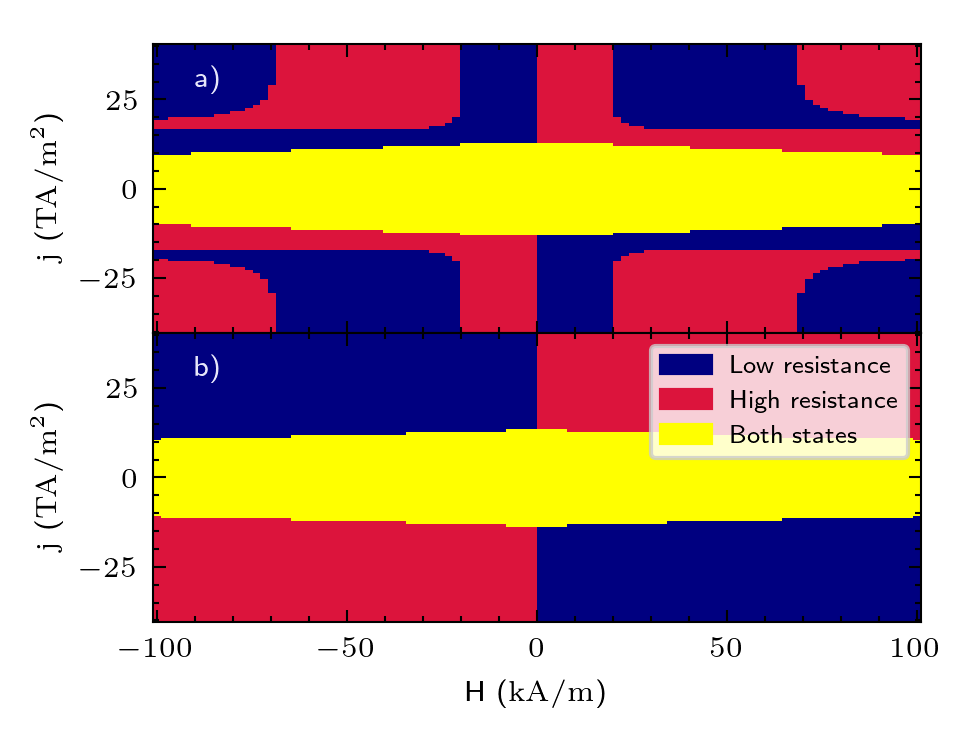

In [9]:
from matplotlib import colors
import matplotlib.patches as mpatches

eps = 0
color_mask_step = R_matrix_step.copy()
color_mask_step[color_mask_step > eps] = 1
color_mask_step[color_mask_step < eps] = -1
color_mask_step[data_matrix_step != 0] = 0

color_mask_gauss = R_matrix_gauss.copy()
color_mask_gauss[color_mask_gauss > eps] = 1
color_mask_gauss[color_mask_gauss < eps] = -1
color_mask_gauss[data_matrix_gauss != 0] = 0

cmap = colors.ListedColormap(['navy', 'yellow', 'crimson'])

with plt.style.context(['science', 'nature']):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharey='col', sharex='col', dpi=300)
    ax1.pcolor(field_values / 1e3,
               current_values / 1e12,
               color_mask_step.T,
               cmap=cmap)
    ax2.pcolor(field_values / 1e3,
               current_values / 1e12,
               color_mask_gauss.T,
               cmap=cmap)

    red_patch = mpatches.Patch(color='crimson', label='High resistance')
    blue_patch = mpatches.Patch(color='navy', label='Low resistance')
    yellow_patch = mpatches.Patch(color='yellow', label='Both states')
    ax2.legend(handles=[blue_patch, red_patch, yellow_patch], frameon=True,
    # frame color 
    facecolor='white', fontsize=6
    )

    ax1.set_ylabel("$\mathrm{j}$ ($\mathrm{TA/m^2}$)")
    ax2.set_ylabel("$\mathrm{j}$ ($\mathrm{TA/m^2}$)")
    ax2.set_xlabel("H ($\mathrm{kA/m}$)")

    fig.subplots_adjust(hspace=0.)
    fig.align_ylabels()

    import matplotlib.transforms as mtransforms
    for label, ax in zip(['a)', 'b)'], (ax1, ax2)):
        # label physical distance in and down:
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72,
                                              fig.dpi_scale_trans)
        ax.text(0.0,
                1.0,
                label,
                transform=ax.transAxes + trans,
                fontsize='medium',
                verticalalignment='top',
                color='lavender',
                bbox=dict(facecolor='none', alpha=0.4, edgecolor='none', pad=3.0))